In [2]:
import re
import itertools
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('newsprint.mplstyle')

In [4]:
# local lib
import sys
sys.path.append('../analysis')
from readers import read_ldjson

# Surname mentions in inaugural addresses

In [5]:
inaugural_speeches = list(read_ldjson('../data/tapp/inaugurals.json'))

In [6]:
surnames_list = [speech['author'].split()[-1] for speech in inaugural_speeches]
surnames = set(surnames_list)

In [7]:
titles_ordered = [speech['author'] + ': ' + speech['title'] for speech in inaugural_speeches]
surnames_ordered = sorted(list(surnames), key=surnames_list.index)

In [8]:
def iter_surnames(speeches, surnames):
    for speech in speeches:
        text = speech['text']
        title = speech['author'] + ': ' + speech['title']
        for surname in surnames:
            surname_count = text.count(surname)
            yield dict(title=title, surname=surname, count=surname_count)

In [9]:
df_surnames = pd.DataFrame(iter_surnames(inaugural_speeches, surnames))

In [10]:
df_xtab = df_surnames.pivot(index='title', columns='surname', values='count')
# reorder columns
df_xtab = df_xtab[surnames_ordered]
# reorder rows
df_xtab = df_xtab.reindex(titles_ordered)

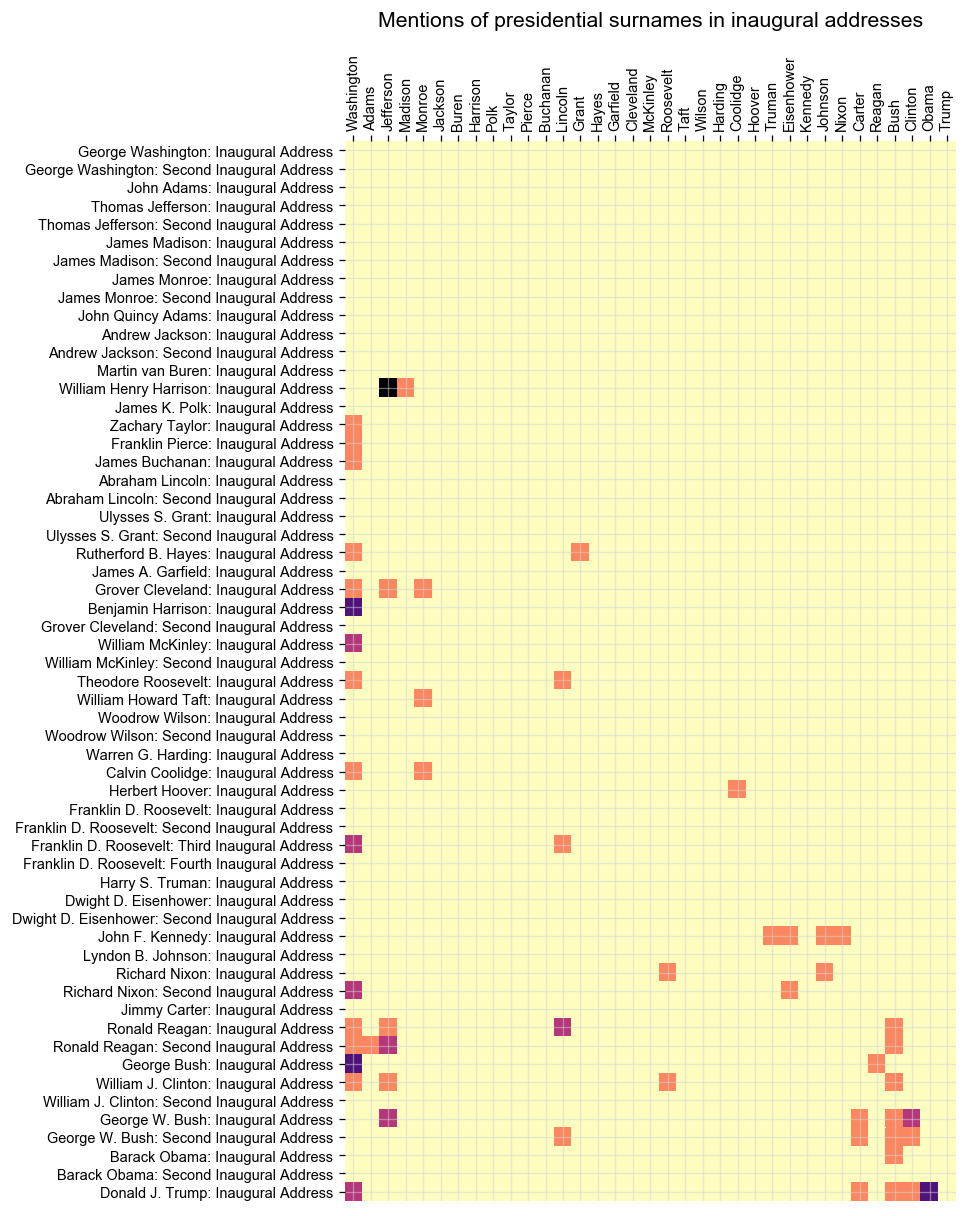

In [12]:
# based on https://stackoverflow.com/a/16124677
plt.figure(figsize=(8.5, 10.5))
ax = plt.axes()
ax.set_frame_on(False)
plt.pcolor(df_xtab, cmap=plt.cm.magma_r)
ax.set_yticks(np.arange(df_xtab.shape[0]) + 0.5, minor=False)
ax.set_yticklabels(df_xtab.index, minor=False, size=9)
ax.set_xticks(np.arange(df_xtab.shape[1]) + 0.5, minor=False)
ax.set_xticklabels(df_xtab.columns, minor=False, rotation=90, size=9)
# flip x-ticks/labels to top
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
# set the x/y tick labels
ax.grid(True, alpha=0.5)
plt.title('Mentions of presidential surnames in inaugural addresses', y=1.10)
plt.tight_layout()
# plt.savefig('Mentions-in-speeches-inaugurals.pdf')

# Self mentions in speeches

In [9]:
def iter_author_texts(speeches):
    for speech in speeches:
        yield speech['author'], speech['text']

In [10]:
def iter_author_text(speeches):
    keyfunc = lambda (author, text): author
    for author, author_texts in itertools.groupby(sorted(iter_author_texts(speeches), key=keyfunc), keyfunc):
        yield author, '\n\n'.join(text for author, text in author_texts)

In [11]:
candidates_speeches = [speech for speech in read_ldjson('../data/tapp/election2016.json') 
                       if speech['category'] == 'campaign speeches']

In [12]:
candidates_text = list(iter_author_text(candidates_speeches))

In [13]:
candidate_fullnames = [fullname for fullname, _ in candidates_text]

In [14]:
print 'Candidates:', ', '.join(candidate_fullnames)

Candidates: Ben Carson, Bernie Sanders, Bobby Jindal, Carly Fiorina, Chris Christie, Donald J. Trump, George Pataki, Hillary Clinton, Jeb Bush, Jim Webb, John Kasich, Lincoln Chafee, Lindsey Graham, Marco Rubio, Martin O'Malley, Mike Huckabee, Rand Paul, Rick Perry, Rick Santorum, Scott Walker, Ted Cruz


In [15]:
def create_candidate_regex(fullname):
    '''
    For a fullname like 'Hillary Clinton', matches substrings like:
    
        Hillary Clinton
        Hillary R. Clinton
        Hillary Rodham Clinton (and Hillary Almost Clinton)
        Clinton
        Hillary
        
    The longer matches come first so that overlapping matches are avoided.
    '''
    parts = fullname.split()
    format_args = dict(firstname=parts[0], lastname=parts[-1])
    patterns = [
        r'{firstname} {lastname}',
        r'{firstname} [A-Z](?:\.|\w+) {lastname}',
        r'{lastname}',
        r'{firstname}',
    ]
    return re.compile('(' + '|'.join(pattern.format(**format_args) for pattern in patterns) + ')')

In [16]:
candidates_regexes = [(fullname, create_candidate_regex(fullname)) for fullname in candidate_fullnames]

In [17]:
def iter_candidates_counts():
    '''
    For each combination of candidates (including themselves), speaker & target, 
    count how many mentions of target are in speaker's speeches
    '''
    for speaker_candidate, speaker_candidate_text in candidates_text:
        for target_candidate, target_candidate_re in candidates_regexes:
            for _ in target_candidate_re.finditer(speaker_candidate_text):
                yield dict(speaker=speaker_candidate, target=target_candidate)

In [18]:
df = pd.DataFrame(iter_candidates_counts())

In [19]:
df_mentions = df.groupby(['speaker', 'target']).size().to_frame('mentions')
df_mentions['log_mentions'] = np.log(df_mentions.mentions)

In [20]:
df_xtab = df_mentions.reset_index().pivot(index='speaker', columns='target', values='log_mentions').fillna(0.0)

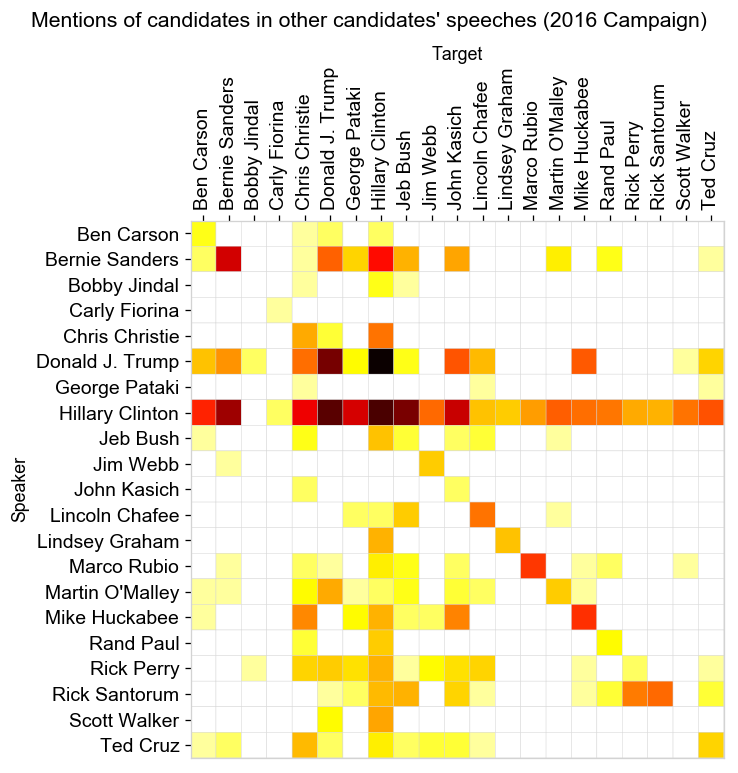

In [21]:
plt.figure(figsize=(6.5, 6.5))
gridcolor = 'lightgray'
# norm=mcolors.LogNorm(vmin=0, vmax=df_xtab.max().max()), 
plt.pcolor(df_xtab, cmap=plt.cm.hot_r, edgecolors=gridcolor)
ax = plt.axes()
# ax.set_frame_on(False)
for spine in ax.spines.values():
    spine.set_edgecolor(gridcolor)
# set up x-axis (speaker)
ax.set_yticks(np.arange(df_xtab.shape[0]) + 0.5, minor=False)
ax.set_yticklabels(df_xtab.index, minor=False, size=12)
ax.set_ylabel(df_xtab.index.name.title())
# set up y-axis (target)
ax.set_xticks(np.arange(df_xtab.shape[1]) + 0.5, minor=False)
ax.set_xticklabels(df_xtab.columns, minor=False, size=12, rotation=90)
ax.set_xlabel(df_xtab.columns.name.title())
# flip x-ticks/labels to top
ax.invert_yaxis()
ax.xaxis.tick_top()
# ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
# set overall titles
plt.tight_layout()
plt.suptitle("Mentions of candidates in other candidates' speeches (2016 Campaign)", y=1.02)
# plt.savefig('Mentions-in-speeches-election2016.pdf')